# Data Exploration
### objective :
*Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Lepiej by było, gdybyśmy wiedzieli, ile taka dostawa dla danego zamówienia może potrwać.*

In [1]:
import datetime
import json # as pandas struggled with json
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import preprocessing
%matplotlib inline

### Load files:

In [2]:
def load_file(filename):
    with open(filename, encoding="utf8") as f:
        data = f.readlines()
        data = [json.loads(line) for line in data] #convert string to dict format
        df = pd.json_normalize(data)
    return df

users = load_file(r'data/users.jsonl')# pd.read_json(r"data/users.jsonl", typ='series', lines=True, dtype='dict')
users.head(30)

,user_id,name,city,street
0,102,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03
1,103,Kajetan Karmelita,Warszawa,ulica Maczka 31
2,104,Eryk Kuncewicz,Police,ulica Krakowska 14/94
3,105,Sylwia Sabak,Radom,ulica Szpitalna 71
4,106,Inga Stępka,Mielec,aleja Liliowa 50
5,107,Filip Włodyka,Gdynia,aleja Ludowa 797
6,108,Jerzy Podgórny,Warszawa,ul. Głogowa 78
7,109,Julita Żuberek,Kutno,ul. Wesoła 214
8,110,Urszula Lepianka,Konin,al. Rataja 60
9,111,Mateusz Posmyk,Kutno,ulica Jadwigi 92


In [3]:
deliveries = load_file("data/deliveries.jsonl")
deliveries.head(30)

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2020-02-10T02:11:41,2020-02-12T13:11:41,360.0
1,20002,2020-03-18T08:22:20,None,360.0
2,20003,2020-01-21T18:07:56,2020-01-24T05:07:56,360.0
3,20004,2020-02-21T15:33:36,2020-02-24T02:33:36,NaN
4,20005,2020-03-09T14:46:19,2020-03-13T19:46:19,620.0
5,20006,2020-02-02T02:07:04,2020-02-06T07:07:04,620.0
6,20007,2020-01-20T20:33:10,2020-01-25T01:33:10,620.0
7,20008,2020-02-02T20:41:01,2020-02-05T07:41:01,360.0
8,20009,2020-01-31T02:24:21,2020-02-04T07:24:21,620.0
9,20010,2020-01-17T04:30:21,2020-01-19T15:30:21,360.0


In [4]:
sessions = load_file("data/sessions.jsonl")
sessions.head(30)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2020-02-10T01:49:08,102.0,1081.0,VIEW_PRODUCT,0,NaN
1,100001,2020-02-10T01:52:15,102.0,NaN,VIEW_PRODUCT,0,NaN
2,100001,2020-02-10T01:56:33,102.0,1080.0,VIEW_PRODUCT,0,NaN
3,100001,2020-02-10T01:58:07,102.0,1079.0,VIEW_PRODUCT,0,NaN
4,100001,2020-02-10T02:01:33,102.0,1077.0,VIEW_PRODUCT,0,NaN
5,100001,2020-02-10T02:03:54,102.0,1003.0,VIEW_PRODUCT,0,NaN
6,100001,2020-02-10T02:04:56,102.0,1002.0,VIEW_PRODUCT,0,NaN
7,100001,2020-02-10T02:07:25,102.0,1078.0,VIEW_PRODUCT,0,NaN
8,100001,2020-02-10T02:11:41,102.0,1078.0,BUY_PRODUCT,0,20001.0
9,100002,2020-03-18T08:22:14,102.0,1318.0,VIEW_PRODUCT,0,NaN


In [5]:
products = load_file("data/products.jsonl")
products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2.048500e+03
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7.639000e+09
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01


### Obserwacje
Jak widać nie wszystkie sesje zakończone zakupem posiadają id użytkownika, co mogłoby być przydatne by ustalić np miasto dostawy. Dodatkowo nie wszystkie dostawy posiadają informację o czasie dostarczenia.

In [6]:
def clean_nan_rows(dataframe, print_stats = False):
    clean_df = dataframe.dropna(axis=0, how='any')
    if print_stats:
        print('Original Length=', len(dataframe), '\tCleaned Length=', len(clean_df), '\tMissing Data=', len(dataframe) - len(clean_df))
    return clean_df

print("Brakujące user_id w sessions dla operacji BUY_PRODUCT\n")
buy_sessions = sessions[sessions.event_type == 'BUY_PRODUCT']
clean_nan_rows(dataframe=buy_sessions['user_id'], print_stats=True)

print("\nBrakujące czasy dostawy w deliveries\n")
clean_nan_rows(dataframe=deliveries['delivery_timestamp'], print_stats=True)

Brakujące user_id w sessions dla operacji BUY_PRODUCT

Original Length= 7268 	Cleaned Length= 6914 	Missing Data= 354

Brakujące czasy dostawy w deliveries

Original Length= 7268 	Cleaned Length= 6886 	Missing Data= 382


0       2020-02-12T13:11:41
2       2020-01-24T05:07:56
3       2020-02-24T02:33:36
4       2020-03-13T19:46:19
5       2020-02-06T07:07:04
               ...         
7263    2020-03-04T15:13:00
7264    2020-02-20T10:22:58
7265    2020-02-29T13:35:37
7266    2020-02-04T12:34:46
7267    2020-02-18T02:16:05
Name: delivery_timestamp, Length: 6886, dtype: object

Brakujące dane w sessions dla operacji BUY_PRODUCT:


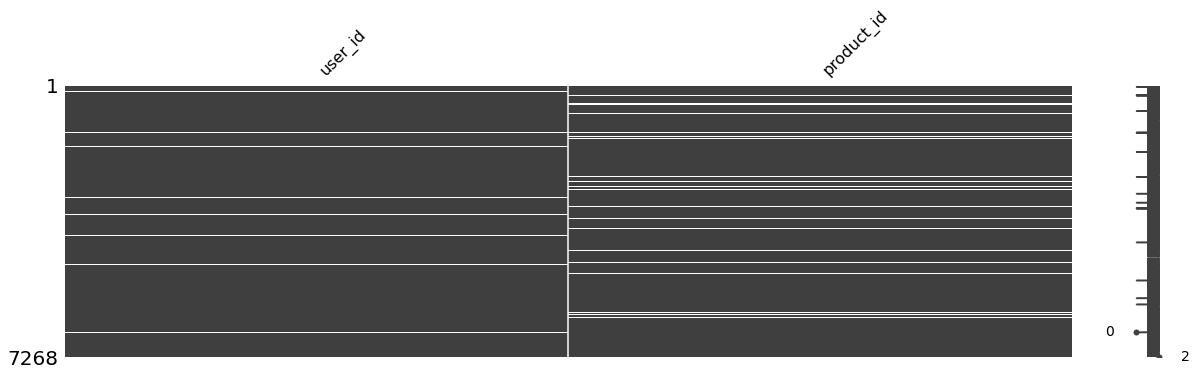

In [7]:
def generate_sparsity_matrix(dataframe):
    missing_df = dataframe.columns[dataframe.isnull().any()].tolist()
    msno.matrix(dataframe[missing_df], figsize=(20, 5))

print("Brakujące dane w sessions dla operacji BUY_PRODUCT:")
generate_sparsity_matrix(buy_sessions)

Brakujące dane w deliveries :


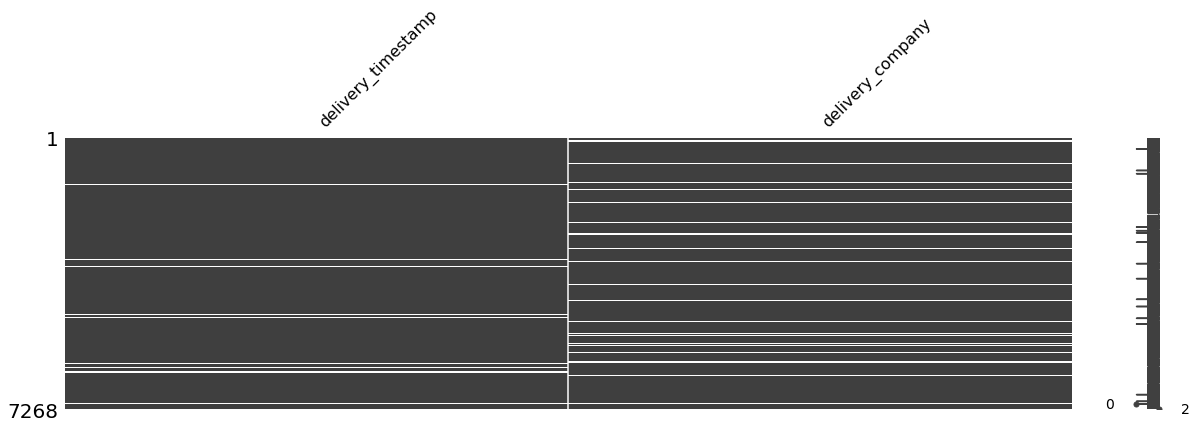

In [8]:
print("Brakujące dane w deliveries :")
generate_sparsity_matrix(deliveries)

### Czy brak danych o dostawie ma związek z firma transportowa?

In [9]:
# TODO


### Transformacje

Połączmy dane w jedną tabelę oraz rozbijmy kategorie na główna i podkategorię

In [10]:
category_path_arr = products['category_path'].str.split(';', 2)
category_arr = []
subcategory_arr = []
for path in category_path_arr:
    if type(path) == float:
        category_arr.append(path)
        subcategory_arr.append(path)
    else:
        category_arr.append(path[0])
        subcategory_arr.append(path[1])

products['category'] = category_arr
products['subcategory'] = subcategory_arr

products

,product_id,product_name,category_path,price,category,subcategory
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01,Telefony i akcesoria,Telefony stacjonarne
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2.048500e+03,Komputery,Drukarki i skanery
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7.639000e+09,Komputery,Drukarki i skanery
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01,Gry i konsole,Gry na konsole
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01,Gry i konsole,Gry na konsole
...,...,...,...,...,...,...
314,1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,5.499000e+01,Telefony i akcesoria,Akcesoria telefoniczne
315,1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,-2.490000e+02,Telefony i akcesoria,Akcesoria telefoniczne
316,1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1.303960e+03,Telefony i akcesoria,Akcesoria telefoniczne
317,1318,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,5.530000e+02,Sprzęt RTV,Audio


In [11]:
# inner join sessins and deliveries
merged_data = pd.merge(left=sessions, right=deliveries, left_on='purchase_id', right_on='purchase_id')

# left join users
merged_data = pd.merge(left=merged_data, right=users, how='left', left_on='user_id', right_on='user_id')

# left join products
merged_data = pd.merge(left=merged_data, right=products, how='left', left_on='product_id', right_on='product_id')

merged_data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,name,city,street,product_name,category_path,price,category,subcategory
0,100001,2020-02-10T02:11:41,102.0,1078.0,BUY_PRODUCT,0,20001.0,2020-02-10T02:11:41,2020-02-12T13:11:41,360.0,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,Kyocera FS-3540MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,5.126000e+03,Komputery,Drukarki i skanery
1,100002,2020-03-18T08:22:20,102.0,1318.0,BUY_PRODUCT,0,20002.0,2020-03-18T08:22:20,None,360.0,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,5.530000e+02,Sprzęt RTV,Audio
2,100003,2020-01-21T18:07:56,102.0,1046.0,BUY_PRODUCT,10,20003.0,2020-01-21T18:07:56,2020-01-24T05:07:56,360.0,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,LEGO Batman 2 DC Super Heroes (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,6.118000e+01,Gry i konsole,Gry na konsole
3,100005,2020-02-21T15:33:36,102.0,1001.0,BUY_PRODUCT,15,20004.0,2020-02-21T15:33:36,2020-02-24T02:33:36,NaN,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01,Telefony i akcesoria,Telefony stacjonarne
4,100006,2020-03-09T14:46:19,102.0,1201.0,BUY_PRODUCT,0,20005.0,2020-03-09T14:46:19,2020-03-13T19:46:19,620.0,Oliwier Maślankiewicz,Konin,pl. Kwiatowa 03,Jabra Speak 410,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,3.274700e+02,Telefony i akcesoria,Akcesoria telefoniczne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263,110434,2020-02-28T13:13:00,301.0,1077.0,BUY_PRODUCT,0,27264.0,2020-02-28T13:13:00,2020-03-04T15:13:00,620.0,Ada Laszkiewicz,Szczecin,ul. Sportowa 70,Kyocera FS-C2026MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,3.777000e+03,Komputery,Drukarki i skanery
7264,110436,2020-02-16T21:22:58,301.0,1037.0,BUY_PRODUCT,10,27265.0,2020-02-16T21:22:58,2020-02-20T10:22:58,360.0,Ada Laszkiewicz,Szczecin,ul. Sportowa 70,LCD Asus VK248H,Komputery;Monitory;Monitory LCD,7.990000e+08,Komputery,Monitory
7265,110437,2020-02-24T11:35:37,301.0,1012.0,BUY_PRODUCT,15,27266.0,2020-02-24T11:35:37,2020-02-29T13:35:37,620.0,Ada Laszkiewicz,Szczecin,ul. Sportowa 70,Fallout New Vegas (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,6.900000e+01,Gry i konsole,Gry na konsole
7266,110439,2020-01-31T23:34:46,301.0,1007.0,BUY_PRODUCT,10,27267.0,2020-01-31T23:34:46,2020-02-04T12:34:46,360.0,Ada Laszkiewicz,Szczecin,ul. Sportowa 70,Dead Space 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,8.999000e+01,Gry i konsole,Gry na konsole


### Odrzućmy część kolumn która zdaje się być zbędne
- id sesji - kolumna identyfikacyjna
- id zakupu - kolumna identyfikacyjna
- id użytkownika - kolumna identyfikacyjna
- id produktu - kolumna identyfikacyjna, zbyt rozdrobniona
- product name - nazwa produktu jest zbyt rozdrobniona *[zbyt wiele różnych wartości]*, kategoria do 2 poziomu wydaje się być dobrym zastępstwem
- typ zdarzenia - rozpatrujemy wyłącznie zakup
- oferowana obniżka - nie ma znaczenia na dostawę *(opcjonalnie jako wart binarna)*
- imie i nazwisko użytkownika - konkretny użytkownik nie powinien być powiązany z dostawą
- timestamp sesji - interesuje nas czas dostawy od czasu *zakupu* do *dostarczenia*
- ulica - zbyt rozdrobniona kolumna *[zbyt wiele różnych wartości]*


In [12]:
columns = ['session_id', 'purchase_id','user_id', 'product_id', 'event_type',
           'offered_discount', 'name', 'timestamp', 'product_name', 'street']
for col in columns:
    merged_data = merged_data.drop(col, axis=1)

merged_data


,purchase_timestamp,delivery_timestamp,delivery_company,city,category_path,price,category,subcategory
0,2020-02-10T02:11:41,2020-02-12T13:11:41,360.0,Konin,Komputery;Drukarki i skanery;Biurowe urządzeni...,5.126000e+03,Komputery,Drukarki i skanery
1,2020-03-18T08:22:20,None,360.0,Konin,Sprzęt RTV;Audio;Słuchawki,5.530000e+02,Sprzęt RTV,Audio
2,2020-01-21T18:07:56,2020-01-24T05:07:56,360.0,Konin,Gry i konsole;Gry na konsole;Gry PlayStation3,6.118000e+01,Gry i konsole,Gry na konsole
3,2020-02-21T15:33:36,2020-02-24T02:33:36,NaN,Konin,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01,Telefony i akcesoria,Telefony stacjonarne
4,2020-03-09T14:46:19,2020-03-13T19:46:19,620.0,Konin,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,3.274700e+02,Telefony i akcesoria,Akcesoria telefoniczne
...,...,...,...,...,...,...,...,...
7263,2020-02-28T13:13:00,2020-03-04T15:13:00,620.0,Szczecin,Komputery;Drukarki i skanery;Biurowe urządzeni...,3.777000e+03,Komputery,Drukarki i skanery
7264,2020-02-16T21:22:58,2020-02-20T10:22:58,360.0,Szczecin,Komputery;Monitory;Monitory LCD,7.990000e+08,Komputery,Monitory
7265,2020-02-24T11:35:37,2020-02-29T13:35:37,620.0,Szczecin,Gry i konsole;Gry na konsole;Gry Xbox 360,6.900000e+01,Gry i konsole,Gry na konsole
7266,2020-01-31T23:34:46,2020-02-04T12:34:46,360.0,Szczecin,Gry i konsole;Gry na konsole;Gry Xbox 360,8.999000e+01,Gry i konsole,Gry na konsole


### Kolumny wyliczane.
Przydatny będzie właściwy czas dostawy, wyrażany np. w godzinach

In [13]:
merged_data['delivery_timestamp'] = \
    pd.to_datetime(merged_data.delivery_timestamp)
merged_data['purchase_timestamp'] = \
    pd.to_datetime(merged_data.purchase_timestamp)
merged_data['delivery_total_time'] = \
    merged_data['delivery_timestamp'] - merged_data['purchase_timestamp']

merged_data['delivery_total_time_hours'] = \
    merged_data['delivery_total_time'].dt.total_seconds()/3600

print(merged_data[['delivery_total_time','delivery_total_time_hours']])

     delivery_total_time  delivery_total_time_hours
0        2 days 11:00:00                       59.0
1                    NaT                        NaN
2        2 days 11:00:00                       59.0
3        2 days 11:00:00                       59.0
4        4 days 05:00:00                      101.0
...                  ...                        ...
7263     5 days 02:00:00                      122.0
7264     3 days 13:00:00                       85.0
7265     5 days 02:00:00                      122.0
7266     3 days 13:00:00                       85.0
7267     3 days 17:00:00                       89.0

[7268 rows x 2 columns]


### simple base model experiment
- no imputation, no parameter scaling

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

clean_data = merged_data

# information form these columns has been transferred to delivery_total_time and category + subcategory
columns = ['purchase_timestamp', 'delivery_timestamp', 'category_path']
for col in columns:
    clean_data = clean_data.drop(col, axis=1)

clean_data =  clean_data.dropna(axis=0, how='any')

target = clean_data['delivery_total_time_hours']
data = clean_data.drop(['delivery_total_time','delivery_total_time_hours'], axis=1)

# code labels
le_cat = preprocessing.LabelEncoder()
le_cat.fit(np.unique(np.array(data['category'])))
data['category'] = le_cat.transform(data['category'])

le_subcat = preprocessing.LabelEncoder()
le_subcat.fit(np.unique(np.array(data['subcategory'])))
data['subcategory'] = le_subcat.transform(data['subcategory'])

le_city = preprocessing.LabelEncoder()
le_city.fit(np.unique(np.array(data['city'])))
data['city'] = le_city.transform(data['city'])

In [15]:
def train_tree_reg(data, target, k_model, k_fold_ratio=5, rand=3228):
    k_fold = KFold(n_splits=k_fold_ratio, random_state=rand, shuffle=True)
    data_arr = np.array(data)
    target_arr = np.array(target)

    max_errors = []
    mean_absolute_errors = []
    mean_squared_errors = []

    for train_index, test_index in k_fold.split(data_arr):
        train_X, valid_X = data_arr[train_index], data_arr[test_index]
        train_y, valid_y = target_arr[train_index], target_arr[test_index]

        k_model = k_model.fit(train_X, train_y)

        k_predict = k_model.predict(valid_X)

        # code for calculating metrics
        max_errors.append(max_error(valid_y, k_predict))
        mean_absolute_errors.append(mean_absolute_error(valid_y, k_predict))
        mean_squared_errors.append(mean_squared_error(valid_y, k_predict))

    # train resulting model
    k_model.fit(data, target)

    return k_model, \
           np.max(max_errors), \
           np.average(mean_absolute_errors), \
           np.average(mean_squared_errors)

# test data
x_train, x_test, y_train, y_test = \
    train_test_split(data, target, test_size=0.2, random_state=0)

In [16]:
print('DecisionTreeRegressor')

for i in range(1,7):
    k_model = DecisionTreeRegressor(max_depth=i)

    print('> depth = ', i, ' | k-fold')

    model, err, avg, avg_sqr = train_tree_reg(x_train, y_train, k_model, 10)

    print('\tmax error = ', err,
          '\n\tavg error = ', avg,
          '\n\tavg square error = ', avg_sqr)
    print('> depth = ', i, ' | test model')

    test_predictions = model.predict(x_test)

    print('\tmax error = ', max_error(y_test, test_predictions),
          '\n\tavg error = ', mean_absolute_error(y_test, test_predictions),
          '\n\tavg square error = ', mean_squared_error(y_test, test_predictions))

DecisionTreeRegressor
> depth =  1  | k-fold
	max error =  28.613802718717317 
	avg error =  12.188053895835923 
	avg square error =  237.9438937239716
> depth =  1  | test model
	max error =  28.46969696969696 
	avg error =  12.169989837065206 
	avg square error =  236.01198783941084
> depth =  2  | k-fold
	max error =  24.224768797748297 
	avg error =  9.738650063059783 
	avg square error =  152.86937907402015
> depth =  2  | test model
	max error =  24.057517291590827 
	avg error =  9.955123892434651 
	avg square error =  157.92576914712672
> depth =  3  | k-fold
	max error =  27.47232645403377 
	avg error =  6.520483160200506 
	avg square error =  95.60367287967567
> depth =  3  | test model
	max error =  27.34314550042052 
	avg error =  6.325022287304135 
	avg square error =  88.59199772020592
> depth =  4  | k-fold
	max error =  23.48465829846583 
	avg error =  5.792592600818785 
	avg square error =  71.53713524457373
> depth =  4  | test model
	max error =  23.363579080025204 
	

In [17]:
print('KNeighborsRegressor')

for weight in ['uniform', 'distance']:
    for i in [2, 3, 4, 6, 8, 12]:
        k_model = KNeighborsRegressor(n_neighbors=i, weights=weight)

        print('> n_neighbors = ', i, ' | weight : ', weight, ' | k-fold')

        model, err, avg, avg_sqr = train_tree_reg(x_train, y_train, k_model, 10)

        print('\tmax error = ', err,
              '\n\tavg error = ', avg,
              '\n\tavg square error = ', avg_sqr)
        print('> n_neighbors = ', i, ' | weight : ', weight, ' | test model')

        test_predictions = model.predict(x_test)

        print('\tmax error = ', max_error(y_test, test_predictions),
              '\n\tavg error = ', mean_absolute_error(y_test, test_predictions),
              '\n\tavg square error = ', mean_squared_error(y_test, test_predictions))


KNeighborsRegressor
> n_neighbors =  2  | weight :  uniform  | k-fold
	max error =  51.99999999999999 
	avg error =  3.4303006585339526 
	avg square error =  91.10609346324085
> n_neighbors =  2  | weight :  uniform  | test model
	max error =  51.99999999999999 
	avg error =  3.114406779661017 
	avg square error =  81.86652542372882
> n_neighbors =  3  | weight :  uniform  | k-fold
	max error =  51.99999999999999 
	avg error =  4.4804636426883535 
	avg square error =  107.21503007784854
> n_neighbors =  3  | weight :  uniform  | test model
	max error =  48.0 
	avg error =  4.266384180790961 
	avg square error =  94.87297551789077
> n_neighbors =  4  | weight :  uniform  | k-fold
	max error =  51.99999999999999 
	avg error =  5.310196480621829 
	avg square error =  116.24626049201122
> n_neighbors =  4  | weight :  uniform  | test model
	max error =  47.5 
	avg error =  5.063135593220339 
	avg square error =  107.33633474576271
> n_neighbors =  6  | weight :  uniform  | k-fold
	max erro